# 1.Load requirments


In [69]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt


In [70]:
import pandas as pd
df = pd.read_csv('outputs/df_cleaned.csv', low_memory=False)
df_season_perf = pd.read_csv('outputs/df_season_wise_performance.csv')
player_impact_merged = pd.read_csv('outputs/impact_scores_with_role.csv')

# 2. Team strength calculation


In [71]:
def calculate_team_strength_with_allrounders(player_impact_merged):
    """
    Calculate team strength using:
    - Top 7 batters (batting impact)
    - Top 5 bowlers (bowling impact) 
    - Top 3 all-rounders (overall impact)
    """
    team_strength_data = []
    
    for season in player_impact_merged['Season'].unique():
        # Get teams from this season
        season_teams = player_impact_merged[player_impact_merged['Season'] == season]['Team'].unique()
        
        for team in season_teams:
            # Get all players in this team for this season
            team_players = player_impact_merged[
                (player_impact_merged['Team'] == team) & 
                (player_impact_merged['Season'] == season)
            ]
            
            if len(team_players) == 0:
                continue
            
            # STRATEGY: Build the ideal playing XI composition
            # Typical T20 team: 5-6 batters + 3-4 bowlers + 1-2 all-rounders
            
            # 1. TOP BATTERS (Primary batting strength)
            batters = team_players.nlargest(7, 'Overall_Impact_Normalized')
            batting_strength = batters['Overall_Impact_Normalized'].mean() if len(batters) > 0 else 50
            
            # 2. TOP BOWLERS (Primary bowling strength)  
            bowlers = team_players.nlargest(5, 'Overall_Impact_Normalized')
            bowling_strength = bowlers['Overall_Impact_Normalized'].mean() if len(bowlers) > 0 else 50
            
            # 3. TOP ALL-ROUNDERS (Game changers - contribute to both)
            all_rounders = team_players[
                team_players['Player_Role'].isin(['All-Rounder'])
            ].nlargest(3, 'Overall_Impact_Normalized')
            
            all_rounder_strength = all_rounders['Overall_Impact_Normalized'].mean() if len(all_rounders) > 0 else 50
            
            # 4. CALCULATE WEIGHTED OVERALL STRENGTH
            # Weights based on T20 team composition importance:
            # - Batting: 40% (5-6 players in lineup)
            # - Bowling: 40% (3-4 frontline bowlers)  
            # - All-rounders: 20% (1-2 game changers)
            
            overall_strength = ( batting_strength + bowling_strength + all_rounder_strength ) /3
                      
            
            # 5. ADDITIONAL METRICS FOR INSIGHTS
            squad_depth = len(team_players)
            team_balance = abs(batting_strength - bowling_strength)  # Lower = more balanced
            
            # Game-changing potential (presence of elite players)
            elite_players = team_players[team_players['Overall_Impact_Normalized'] >= 75]
            game_changers = len(elite_players)
            
            team_strength_data.append({
                'Team': team,
                'Season': season,
                'Overall_Strength': overall_strength,
                'Batting_Strength': batting_strength,
                'Bowling_Strength': bowling_strength,
                'AllRounder_Strength': all_rounder_strength,
                'Squad_Depth': squad_depth,
                'Team_Balance': team_balance,
                'Game_Changers': game_changers,
                'Top_Batter_Score': batters['Batting_Impact_Normalized'].max() if len(batters) > 0 else 0,
                'Top_Bowler_Score': bowlers['Bowling_Impact_Normalized'].max() if len(bowlers) > 0 else 0,
                'Top_AllRounder_Score': all_rounders['Overall_Impact_Normalized'].max() if len(all_rounders) > 0 else 0,
                'Batting_Depth': len(batters),
                'Bowling_Depth': len(bowlers),
                'AllRounder_Depth': len(all_rounders)
            })
    
    return pd.DataFrame(team_strength_data)

# Calculate enhanced team strength
team_strength_enhanced = calculate_team_strength_with_allrounders(player_impact_merged)

print(f"Calculated team strength for {len(team_strength_enhanced)} team-seasons")



Calculated team strength for 156 team-seasons


## 2.1 Testing

In [72]:
# Top overall teams
print("TOP 10 STRONGEST TEAMS:")
top_teams = team_strength_enhanced.nlargest(10, 'Overall_Strength')[
    ['Team', 'Season', 'Overall_Strength', 'Batting_Strength', 'Bowling_Strength', 'AllRounder_Strength', 'Game_Changers']
].round(1)
print(top_teams)


# Teams with best all-rounders
print("TEAMS WITH BEST ALL-ROUNDERS:")
best_allrounder_teams = team_strength_enhanced.nlargest(8, 'AllRounder_Strength')[
    ['Team', 'Season', 'AllRounder_Strength', 'AllRounder_Depth', 'Top_AllRounder_Score']
].round(1)
print(best_allrounder_teams)


# Most balanced teams
print("MOST BALANCED TEAMS (Batting ≈ Bowling):")
balanced_teams = team_strength_enhanced.nsmallest(8, 'Team_Balance')[
    ['Team', 'Season', 'Overall_Strength', 'Batting_Strength', 'Bowling_Strength', 'Team_Balance']
].round(1)
print(balanced_teams)


TOP 10 STRONGEST TEAMS:
                            Team  Season  Overall_Strength  Batting_Strength  \
80              Rajasthan Royals    2008              76.5              74.0   
58         Kolkata Knight Riders    2024              73.1              72.8   
29   Royal Challengers Bangalore    2016              72.2              76.2   
153          Chennai Super Kings    2021              72.1              73.9   
43              Rajasthan Royals    2022              71.4              74.4   
87               Deccan Chargers    2009              71.0              74.1   
16           Chennai Super Kings    2013              70.8              76.0   
112               Mumbai Indians    2010              70.6              74.5   
137               Mumbai Indians    2019              69.7              72.4   
70                Gujarat Titans    2025              69.6              75.5   

     Bowling_Strength  AllRounder_Strength  Game_Changers  
80               76.2              

In [73]:

def analyze_team_strength(team_name, season):
    """Detailed analysis of a specific team's strength"""
    team_data = team_strength_enhanced[
        (team_strength_enhanced['Team'] == team_name) & 
        (team_strength_enhanced['Season'] == season)
    ]
    
    if len(team_data) == 0:
        print(f"No data for {team_name} in {season}")
        return
    
    team_data = team_data.iloc[0]
    
    print(f"DETAILED ANALYSIS: {team_name} ({season})")
    print("="*50)
    
    print(f"Overall Strength: {team_data['Overall_Strength']:.1f}/100")
    print(f"Batting Strength: {team_data['Batting_Strength']:.1f}/100 (Top {team_data['Batting_Depth']} batters)")
    print(f"Bowling Strength: {team_data['Bowling_Strength']:.1f}/100 (Top {team_data['Bowling_Depth']} bowlers)")
    print(f"All-Rounder Strength: {team_data['AllRounder_Strength']:.1f}/100 (Top {team_data['AllRounder_Depth']} all-rounders)")
    print(f"Game Changers: {team_data['Game_Changers']} elite players")
    print(f"Team Balance: {team_data['Team_Balance']:.1f} (lower = more balanced)")
    
    # Strength assessment
    if team_data['Overall_Strength'] >= 80:
        strength_verdict = "ELITE TEAM - Championship contender"
    elif team_data['Overall_Strength'] >= 70:
        strength_verdict = "STRONG TEAM - Playoff contender" 
    elif team_data['Overall_Strength'] >= 60:
        strength_verdict = "COMPETITIVE TEAM - Mid-table"
    else:
        strength_verdict = "DEVELOPING TEAM - Rebuilding phase"
    
    # Balance assessment
    if team_data['Team_Balance'] <= 5:
        balance_verdict = "Well-balanced squad"
    elif team_data['Team_Balance'] <= 10:
        balance_verdict = "Slightly imbalanced"
    else:
        balance_verdict = "Heavily reliant on one department"
    
    print(f"\nASSESSMENT: {strength_verdict}")
    print(f"BALANCE: {balance_verdict}")

# Analyze some famous teams
print("\n" + "="*60)
print("SAMPLE TEAM ANALYSES")
print("="*60)

analyze_team_strength("Royal Challengers Bangalore", 2016)
analyze_team_strength("Mumbai Indians", 2020)
analyze_team_strength("Chennai Super Kings", 2021)



SAMPLE TEAM ANALYSES
DETAILED ANALYSIS: Royal Challengers Bangalore (2016)
Overall Strength: 72.2/100
Batting Strength: 76.2/100 (Top 7 batters)
Bowling Strength: 81.3/100 (Top 5 bowlers)
All-Rounder Strength: 59.1/100 (Top 2 all-rounders)
Game Changers: 2 elite players
Team Balance: 5.1 (lower = more balanced)

ASSESSMENT: STRONG TEAM - Playoff contender
BALANCE: Slightly imbalanced
DETAILED ANALYSIS: Mumbai Indians (2020)
Overall Strength: 67.0/100
Batting Strength: 75.7/100 (Top 7 batters)
Bowling Strength: 78.1/100 (Top 5 bowlers)
All-Rounder Strength: 47.1/100 (Top 3 all-rounders)
Game Changers: 5 elite players
Team Balance: 2.4 (lower = more balanced)

ASSESSMENT: COMPETITIVE TEAM - Mid-table
BALANCE: Well-balanced squad
DETAILED ANALYSIS: Chennai Super Kings (2021)
Overall Strength: 72.1/100
Batting Strength: 73.9/100 (Top 7 batters)
Bowling Strength: 76.2/100 (Top 5 bowlers)
All-Rounder Strength: 66.1/100 (Top 3 all-rounders)
Game Changers: 2 elite players
Team Balance: 2.3 (l

# 3.Preparing features

In [74]:
def prepare_match_features_enhanced(df):
    """
    Step 1: Create match-level features with ALL team names and actual winner
    """
    print("Converting ball-by-ball data to match summaries...")
    
    match_features = []
    
    for match_id in df['match_id'].unique():
        match_data = df[df['match_id'] == match_id].copy()
        
        # Skip incomplete matches or matches with only 1 innings
        if len(match_data[match_data['innings'] == 2]) == 0:
            continue
        
        # Get basic match info
        season = match_data['year'].iloc[0]
        venue = match_data['venue'].iloc[0]
        toss_winner = match_data['toss_winner'].iloc[0]
        toss_decision = match_data['toss_decision'].iloc[0]
        
        # Get ACTUAL MATCH WINNER from the data  
        if 'match_won_by' in match_data.columns and not match_data['match_won_by'].isna().all():
            actual_winner = match_data['match_won_by'].iloc[0]
        # Method 3: Determine winner from innings results (fallback)
       
        else: #NOT NEEDED for this data
            # Get team batting first and second
            first_innings_team = match_data[match_data['innings'] == 1]['batting_team'].iloc[0]
            second_innings_team = match_data[match_data['innings'] == 2]['batting_team'].iloc[0]
            
            # Get final scores
            first_innings_score = match_data[match_data['innings'] == 1]['team_runs'].iloc[-1]
            second_innings_score = match_data[match_data['innings'] == 2]['team_runs'].iloc[-1]
            
            # Determine winner
            if second_innings_score >= first_innings_score:
                actual_winner = second_innings_team  # Chasing team won
            else:
                actual_winner = first_innings_team   # Defending team won
        



        # First innings stats
        first_innings = match_data[match_data['innings'] == 1]
        if len(first_innings) == 0:
            continue
            
        first_innings_runs = first_innings['team_runs'].iloc[-1]
        first_innings_wickets = first_innings['team_wicket'].iloc[-1]
        team_batting_first = first_innings['batting_team'].iloc[0]
        team_bowling_first = first_innings['bowling_team'].iloc[0]
        
        # Second innings stats (this is what we're predicting)
        second_innings = match_data[match_data['innings'] == 2]
        target_runs = second_innings['runs_target'].iloc[0]
        chasing_team = second_innings['batting_team'].iloc[0]
        defending_team = second_innings['bowling_team'].iloc[0]
        
        # Actual result (our target variable)
        final_runs = second_innings['team_runs'].iloc[-1]
        won_chasing = 1 if final_runs >= target_runs else 0
        
        # Feature engineering
        features = {
            'match_id': match_id,
            'season': season,
            'venue': venue,
            
            # ALL TEAM NAMES
            'team_batting_first': team_batting_first,
            #'team_bowling_first': team_bowling_first,
            'chasing_team': chasing_team,
            'defending_team': defending_team,
            
            # TOSS INFORMATION
            'toss_winner': toss_winner,
            'toss_decision': toss_decision,
            #'is_toss_winner_chasing': 1 if toss_winner == chasing_team else 0,
            #'is_batting_first_won_toss': 1 if toss_decision == 'bat' else 0,
            
            # MATCH STATS
            'first_innings_runs': first_innings_runs,
            'first_innings_wickets': first_innings_wickets,
            'target_runs': target_runs,
            'required_run_rate': target_runs / 20,  # Initial required RR
            
            # ACTUAL RESULTS
            'actual_winner': actual_winner,
            'won_chasing': won_chasing,  # TARGET VARIABLE
            
            # ADDITIONAL CONTEXT
            'final_runs_chasing': final_runs,
            'runs_margin(if won chasing)': abs(final_runs - target_runs) if won_chasing else 0
        }
        
        match_features.append(features)
    
    features_df = pd.DataFrame(match_features)
    print(f"Created features for {len(features_df)} complete matches")
    return features_df

# Execute Step 1
features_df = prepare_match_features_enhanced(df)

# Display what we created
print("\nENHANCED FEATURES CREATED:")
print(f"Total matches with features: {len(features_df)}")
print(f"Win rate while chasing: {features_df['won_chasing'].mean():.2%}")

print("\nSAMPLE OF ENHANCED FEATURES:")
print(features_df.head(8))

print("\nFEATURE SUMMARY:")
print(features_df[['target_runs', 'first_innings_runs', 'required_run_rate']].describe())

Converting ball-by-ball data to match summaries...
Created features for 1164 complete matches

ENHANCED FEATURES CREATED:
Total matches with features: 1164
Win rate while chasing: 53.35%

SAMPLE OF ENHANCED FEATURES:
   match_id  season                                       venue  \
0    335982    2008                       M Chinnaswamy Stadium   
1    335983    2008  Punjab Cricket Association Stadium, Mohali   
2    335984    2008                            Feroz Shah Kotla   
3    335985    2008                            Wankhede Stadium   
4    335986    2008                                Eden Gardens   
5    335987    2008                      Sawai Mansingh Stadium   
6    335988    2008   Rajiv Gandhi International Stadium, Uppal   
7    335989    2008             MA Chidambaram Stadium, Chepauk   

      team_batting_first                 chasing_team         defending_team  \
0  Kolkata Knight Riders  Royal Challengers Bangalore  Kolkata Knight Riders   
1    Chennai Super 

In [75]:
features_df.head(200)

,match_id,season,venue,team_batting_first,chasing_team,defending_team,toss_winner,toss_decision,first_innings_runs,first_innings_wickets,target_runs,required_run_rate,actual_winner,won_chasing,final_runs_chasing,runs_margin(if won chasing)
0,335982,2008,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,222,3,223.0,11.15,Kolkata Knight Riders,0,82,0.0
1,335983,2008,"Punjab Cricket Association Stadium, Mohali",Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,240,5,241.0,12.05,Chennai Super Kings,0,207,0.0
2,335984,2008,Feroz Shah Kotla,Rajasthan Royals,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,129,8,130.0,6.50,Delhi Daredevils,1,132,2.0
3,335985,2008,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,Mumbai Indians,bat,165,6,166.0,8.30,Royal Challengers Bangalore,1,166,0.0
4,335986,2008,Eden Gardens,Deccan Chargers,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,110,10,111.0,5.55,Kolkata Knight Riders,1,112,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,501219,2011,Eden Gardens,Kochi Tuskers Kerala,Kolkata Knight Riders,Kochi Tuskers Kerala,Kolkata Knight Riders,field,132,7,133.0,6.65,Kochi Tuskers Kerala,0,126,0.0
196,501220,2011,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Rajasthan Royals,Kings XI Punjab,Rajasthan Royals,field,195,7,196.0,9.80,Kings XI Punjab,0,147,0.0
197,501221,2011,Wankhede Stadium,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Chennai Super Kings,field,164,4,165.0,8.25,Mumbai Indians,0,156,0.0
198,501222,2011,Eden Gardens,Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,171,5,172.0,8.60,Royal Challengers Bangalore,1,175,3.0


## 3.1 Data verification

In [76]:

print(f"Total matches in dataset: {df['match_id'].nunique()}")
print(f"Complete matches (2 innings): {len(features_df)}")

# Check win distribution
chasing_wins = features_df['won_chasing'].sum()
chasing_matches = len(features_df)
print(f"Chasing wins: {chasing_wins}/{chasing_matches} ({chasing_wins/chasing_matches:.1%})")

# Check if we successfully captured actual winners
print(f"\nACTUAL WINNER ANALYSIS:")
print(f"Successfully captured actual winner for {features_df['actual_winner'].notna().sum()} matches")

# Most successful chasing teams
print(f"\nTOP CHASING TEAMS:")
chasing_success = features_df.groupby('chasing_team')['won_chasing'].agg(['count', 'mean']).round(3)
chasing_success = chasing_success[chasing_success['count'] >= 10]  # Minimum 10 chases
top_chasers = chasing_success.nlargest(5, 'mean')
print(top_chasers)


# Sample match analysis with all details
print(f"\nDETAILED SAMPLE MATCH ANALYSIS:")
sample_match = features_df.iloc[0]
print(f"Match ID: {sample_match['match_id']}")
print(f"Teams: {sample_match['team_batting_first']} vs {sample_match['chasing_team']}")
print(f"Toss: {sample_match['toss_winner']} won and chose to {sample_match['toss_decision']}")
print(f"First innings: {sample_match['team_batting_first']} - {sample_match['first_innings_runs']} runs")
print(f"Target: {sample_match['target_runs']} runs for {sample_match['chasing_team']}")
print(f"Result: {sample_match['chasing_team']} {'WON' if sample_match['won_chasing'] else 'LOST'} by chasing")
print(f"Actual Winner: {sample_match['actual_winner']}")

# Check data quality
print(f"\nDATA QUALITY CHECK:")
print(f"Missing values in target variable: {features_df['won_chasing'].isna().sum()}")
print(f"Missing values in team names: {features_df[['team_batting_first', 'chasing_team']].isna().sum().sum()}")
print(f"Seasons covered: {sorted(features_df['season'].unique())}")

# Save this enhanced features dataframe for next steps
features_df.to_csv('outputs/ml_step1_features.csv', index=False)
print(f"\nSaved enhanced features to: outputs/ml_step1_features.csv")


Total matches in dataset: 1169
Complete matches (2 innings): 1164
Chasing wins: 621/1164 (53.4%)

ACTUAL WINNER ANALYSIS:
Successfully captured actual winner for 1164 matches

TOP CHASING TEAMS:
                             count   mean
chasing_team                             
Gujarat Lions                   16  0.750
Royal Challengers Bengaluru     13  0.692
Gujarat Titans                  33  0.667
Chennai Super Kings            115  0.617
Kolkata Knight Riders          138  0.580

DETAILED SAMPLE MATCH ANALYSIS:
Match ID: 335982
Teams: Kolkata Knight Riders vs Royal Challengers Bangalore
Toss: Royal Challengers Bangalore won and chose to field
First innings: Kolkata Knight Riders - 222 runs
Target: 223.0 runs for Royal Challengers Bangalore
Result: Royal Challengers Bangalore LOST by chasing
Actual Winner: Kolkata Knight Riders

DATA QUALITY CHECK:
Missing values in target variable: 0
Missing values in team names: 0
Seasons covered: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 

## 3.2 Incorporating team strength

In [77]:
def add_team_strength_features(features_df, team_strength_df):
    """
    Step 2: Enhance match features with team strength data
    This adds intelligence about how good each team actually is
    """
    print("Merging team strength data with match features...")
    
    # Make a copy to avoid modifying original
    features_enhanced = features_df.copy()
    
    # For CHASING TEAM strength features
    features_enhanced = pd.merge(
        features_enhanced,
        team_strength_df,
        left_on=['chasing_team', 'season'],
        right_on=['Team', 'Season'],
        how='left'
    )
    
    # Rename chasing team strength columns
    chasing_rename_dict = {
        'Overall_Strength': 'chasing_overall_strength',
        'Batting_Strength': 'chasing_batting_strength',
        'Bowling_Strength': 'chasing_bowling_strength',
        'AllRounder_Strength': 'chasing_allrounder_strength',
        'Team_Balance': 'chasing_team_balance',
        'Game_Changers': 'chasing_game_changers',
        'Squad_Depth': 'chasing_squad_depth'
    }
    
    features_enhanced = features_enhanced.rename(columns=chasing_rename_dict)
    
    # For DEFENDING TEAM strength features
    features_enhanced = pd.merge(
        features_enhanced,
        team_strength_df,
        left_on=['defending_team', 'season'],
        right_on=['Team', 'Season'],
        how='left',
        suffixes=('', '_def')
    )
    
    # Rename defending team strength columns
    defending_rename_dict = {
        'Overall_Strength': 'defending_overall_strength',
        'Batting_Strength': 'defending_batting_strength',
        'Bowling_Strength': 'defending_bowling_strength',
        'AllRounder_Strength': 'defending_allrounder_strength',
        'Team_Balance': 'defending_team_balance',
        'Game_Changers': 'defending_game_changers',
        'Squad_Depth': 'defending_squad_depth'
    }
    
    features_enhanced = features_enhanced.rename(columns=defending_rename_dict)
    
    # Calculate STRENGTH DIFFERENTIALS (very important for ML!)
    print("Calculating strength differentials...")
    
    features_enhanced['overall_strength_diff'] = (
        features_enhanced['chasing_overall_strength'] - features_enhanced['defending_overall_strength']
    )
    features_enhanced['batting_strength_diff'] = (
        features_enhanced['chasing_batting_strength'] - features_enhanced['defending_batting_strength']
    )
    features_enhanced['bowling_strength_diff'] = (
        features_enhanced['chasing_bowling_strength'] - features_enhanced['defending_bowling_strength']
    )
    features_enhanced['allrounder_strength_diff'] = (
        features_enhanced['chasing_allrounder_strength'] - features_enhanced['defending_allrounder_strength']
    )
    
    # Fill missing values (for teams without strength data)
    strength_columns = [
        'chasing_overall_strength', 'chasing_batting_strength', 'chasing_bowling_strength',
        'defending_overall_strength', 'defending_batting_strength', 'defending_bowling_strength',
        'overall_strength_diff', 'batting_strength_diff', 'bowling_strength_diff'
    ]
    
    for col in strength_columns:
        features_enhanced[col] = features_enhanced[col].fillna(0)
    
    # Drop redundant columns from merge
    features_enhanced = features_enhanced.drop(['Team', 'Season', 'Team_def', 'Season_def'], axis=1, errors='ignore')
    
    print(f"Added {len([col for col in features_enhanced.columns if 'strength' in col])} team strength features")
    return features_enhanced

# Execute Step 2
features_with_strength = add_team_strength_features(features_df, team_strength_enhanced)

# Display what we added
print("\nTEAM STRENGTH FEATURES ADDED:")
print(f"Total features now: {len(features_with_strength.columns)}")
print(f"Dataset shape: {features_with_strength.shape}")

# Show the new strength-related columns
strength_cols = [col for col in features_with_strength.columns if 'strength' in col]
print(f"\nNEW STRENGTH FEATURES:")
for col in strength_cols:
    print(f"  - {col}")

print(f"\nSAMPLE WITH STRENGTH FEATURES:")
sample_cols = ['chasing_team', 'defending_team', 'chasing_overall_strength', 
               'defending_overall_strength', 'overall_strength_diff', 'won_chasing']
print(features_with_strength[sample_cols].head(8).round(2))

Merging team strength data with match features...
Calculating strength differentials...
Added 12 team strength features

TEAM STRENGTH FEATURES ADDED:
Total features now: 46
Dataset shape: (1164, 46)

NEW STRENGTH FEATURES:
  - chasing_overall_strength
  - chasing_batting_strength
  - chasing_bowling_strength
  - chasing_allrounder_strength
  - defending_overall_strength
  - defending_batting_strength
  - defending_bowling_strength
  - defending_allrounder_strength
  - overall_strength_diff
  - batting_strength_diff
  - bowling_strength_diff
  - allrounder_strength_diff

SAMPLE WITH STRENGTH FEATURES:
                  chasing_team         defending_team  \
0  Royal Challengers Bangalore  Kolkata Knight Riders   
1              Kings XI Punjab    Chennai Super Kings   
2             Delhi Daredevils       Rajasthan Royals   
3  Royal Challengers Bangalore         Mumbai Indians   
4        Kolkata Knight Riders        Deccan Chargers   
5             Rajasthan Royals        Kings XI Pu

### 3.2.1 Testing

In [78]:
# Check strength correlation with winning
if 'overall_strength_diff' in features_with_strength.columns:
    correlation = features_with_strength['overall_strength_diff'].corr(features_with_strength['won_chasing'])
    print(f"Correlation between strength difference and winning: {correlation:.3f}")

# Win rates by strength advantage
print(f"\n🎯 WIN RATES BY STRENGTH ADVANTAGE:")
features_with_strength['strength_advantage'] = np.where(
    features_with_strength['overall_strength_diff'] > 5, 'Strong Chaser',
    np.where(features_with_strength['overall_strength_diff'] < -5, 'Strong Defender', 'Balanced')
)

win_rates_by_strength = features_with_strength.groupby('strength_advantage')['won_chasing'].agg(['count', 'mean'])
print(win_rates_by_strength.round(3))

# Top strongest teams analysis
print(f"\nSTRONGEST TEAMS ANALYSIS:")
team_strength_summary = team_strength_enhanced.groupby('Team')['Overall_Strength'].agg(['mean', 'count']).round(2)
strongest_teams = team_strength_summary.nlargest(8, 'mean')
print(strongest_teams)

# Sample match analysis with strength context
print(f"\nSAMPLE MATCH WITH STRENGTH ANALYSIS:")
sample_match = features_with_strength.iloc[0]
print(f"Match: {sample_match['chasing_team']} vs {sample_match['defending_team']}")
print(f"Chasing Strength: {sample_match['chasing_overall_strength']:.1f}")
print(f"Defending Strength: {sample_match['defending_overall_strength']:.1f}")
print(f"Strength Difference: {sample_match['overall_strength_diff']:+.1f}")
print(f"Target: {sample_match['target_runs']} runs")
print(f"Result: {'WON' if sample_match['won_chasing'] else 'LOST'} while chasing")
print(f"Strength suggested: {'FAVORITE' if sample_match['overall_strength_diff'] > 0 else 'UNDERDOG'}")

# Check for any missing strength data
missing_strength = features_with_strength['chasing_overall_strength'].isna().sum()
total_matches = len(features_with_strength)
print(f"\nDATA QUALITY CHECK:")
print(f"Matches with team strength data: {total_matches - missing_strength}/{total_matches} ({(total_matches - missing_strength)/total_matches:.1%})")

# Save the enhanced dataset
features_with_strength.to_csv('outputs/ml_step2_features_with_strength.csv', index=False)
print(f"\nSaved features with team strength to: outputs/ml_step2_features_with_strength.csv")

Correlation between strength difference and winning: 0.177

🎯 WIN RATES BY STRENGTH ADVANTAGE:
                    count   mean
strength_advantage              
Balanced              864  0.519
Strong Chaser         136  0.735
Strong Defender       164  0.445

STRONGEST TEAMS ANALYSIS:
                              mean  count
Team                                     
Royal Challengers Bengaluru  68.49      2
Punjab Kings                 66.30      5
Kolkata Knight Riders        66.09     18
Deccan Chargers              66.07      5
Rising Pune Supergiant       65.85      1
Chennai Super Kings          65.78     16
Mumbai Indians               65.76     18
Royal Challengers Bangalore  65.16     16

SAMPLE MATCH WITH STRENGTH ANALYSIS:
Match: Royal Challengers Bangalore vs Kolkata Knight Riders
Chasing Strength: 61.3
Defending Strength: 64.4
Strength Difference: -3.1
Target: 223.0 runs
Result: LOST while chasing
Strength suggested: UNDERDOG

DATA QUALITY CHECK:
Matches with team strengt

## 3.3 Pre-processing for ML - encoding, scaling, splitting

In [79]:
def preprocess_for_ml(features_with_strength):
    """
    Step 3: Prepare features for ML models by:
    - Encoding categorical variables
    - Selecting final feature set
    - Handling missing values
    - Creating train/test split
    """
    print("Preprocessing data for machine learning...")
    
    # Make a copy to avoid modifying original
    df_processed = features_with_strength.copy()
    
    # 1. HANDLE CATEGORICAL VARIABLES (Encode text to numbers)
    print("Encoding categorical variables...")
    
    from sklearn.preprocessing import LabelEncoder
    
    # Initialize label encoders (we'll save these for later predictions)
    label_encoders = {}
    
    categorical_columns = ['venue', 'chasing_team', 'defending_team', 'toss_winner', 'toss_decision']
    
    for col in categorical_columns:
        if col in df_processed.columns:
            le = LabelEncoder()
            df_processed[col + '_encoded'] = le.fit_transform(df_processed[col].astype(str))
            label_encoders[col] = le
            print(f"  - Encoded {col}: {len(le.classes_)} unique values")
    
    # 2. SELECT FINAL FEATURE SET FOR ML
    print("\nSelecting final feature set...")
    
    # These are the features our ML model will use
    feature_columns = [
        # Match context features
        'target_runs',
        'first_innings_runs', 
        'first_innings_wickets',
        'required_run_rate',
        
        # Toss and decision features
        'is_toss_winner_chasing',
        'is_batting_first_won_toss',
        
        # Team strength features (from Step 2)
        'chasing_overall_strength',
        'defending_overall_strength', 
        'chasing_batting_strength',
        'defending_bowling_strength',
        'chasing_bowling_strength',
        'defending_batting_strength',
        'chasing_allrounder_strength',
        'defending_allrounder_strength',
        
        # Strength differentials (very important!)
        'overall_strength_diff',
        'batting_strength_diff', 
        'bowling_strength_diff',
        'allrounder_strength_diff',
        
        # Encoded categorical features
        'venue_encoded',
        'chasing_team_encoded',
        'defending_team_encoded', 
        'toss_winner_encoded',
        'toss_decision_encoded'
    ]
    
    # Only include columns that actually exist in our data
    available_features = [col for col in feature_columns if col in df_processed.columns]
    print(f"  - Selected {len(available_features)} features for ML")
    
    # 3. HANDLE MISSING VALUES
    print("\nHandling missing values...")
    
    # Separate features and target
    X = df_processed[available_features].copy()
    y = df_processed['won_chasing']
    
    # Fill any remaining missing values
    missing_before = X.isna().sum().sum()
    X = X.fillna(X.mean())  # Fill numeric columns with mean
    missing_after = X.isna().sum().sum()
    print(f"  - Fixed {missing_before} missing values")
    
    # 4. CREATE TRAIN/TEST SPLIT
    print("\nCreating train/test split...")
    
    from sklearn.model_selection import train_test_split
    
    # Split data: 80% for training, 20% for testing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42,  # For reproducible results
        stratify=y       # Maintain same win/loss ratio in both sets
    )
    
    print(f"  - Training set: {X_train.shape[0]} matches")
    print(f"  - Test set: {X_test.shape[0]} matches")
    print(f"  - Win rate in training: {y_train.mean():.1%}")
    print(f"  - Win rate in test: {y_test.mean():.1%}")
    
    # 5. FEATURE SCALING (Important for some models)
    print("\nApplying feature scaling...")
    
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    
    # Fit scaler on training data only, then transform both
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to DataFrames for better readability
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    print("  - Features scaled to standard normal distribution")
    
    return {
        'X_train': X_train,
        'X_test': X_test,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'feature_names': available_features,
        'label_encoders': label_encoders,
        'scaler': scaler,
        'original_data': df_processed
    }

# Execute Step 3
ml_data = preprocess_for_ml(features_with_strength)


Preprocessing data for machine learning...
Encoding categorical variables...
  - Encoded venue: 59 unique values
  - Encoded chasing_team: 19 unique values
  - Encoded defending_team: 19 unique values
  - Encoded toss_winner: 19 unique values
  - Encoded toss_decision: 2 unique values

Selecting final feature set...
  - Selected 21 features for ML

Handling missing values...
  - Fixed 0 missing values

Creating train/test split...
  - Training set: 931 matches
  - Test set: 233 matches
  - Win rate in training: 53.4%
  - Win rate in test: 53.2%

Applying feature scaling...
  - Features scaled to standard normal distribution


### 3.3.1 Testing

In [80]:
# Feature statistics
print("FEATURE STATISTICS (Training Set):")
feature_stats = ml_data['X_train'].describe().T[['mean', 'std', 'min', 'max']].round(3)
print(feature_stats.head(10))

# Check feature distributions
print(f"\nKEY FEATURE DISTRIBUTIONS:")
key_features = ['target_runs', 'overall_strength_diff', 'required_run_rate', 'first_innings_runs']
for feature in key_features:
    if feature in ml_data['X_train'].columns:
        stats = ml_data['X_train'][feature].describe()
        print(f"  - {feature}: {stats['mean']:.1f} ± {stats['std']:.1f} (range: {stats['min']:.1f}-{stats['max']:.1f})")

# Check correlation with target
print(f"\nFEATURE CORRELATION WITH WINNING:")
correlations = []
for feature in ml_data['X_train'].columns:
    corr = ml_data['X_train'][feature].corr(ml_data['y_train'])
    correlations.append((feature, corr))

# Sort by absolute correlation strength
correlations.sort(key=lambda x: abs(x[1]), reverse=True)
print("Top 10 features by correlation with winning:")
for feature, corr in correlations[:10]:
    print(f"  - {feature}: {corr:+.3f}")

# Data quality check
print(f"\nDATA QUALITY CHECK:")
print(f"Total matches for ML: {len(ml_data['X_train']) + len(ml_data['X_test'])}")
print(f"Features per match: {len(ml_data['feature_names'])}")
print(f"Missing values in training: {ml_data['X_train'].isna().sum().sum()}")
print(f"Missing values in test: {ml_data['X_test'].isna().sum().sum()}")

# Save the preprocessed data
import pickle

with open('outputs/ml_step3_preprocessed_data.pkl', 'wb') as f:
    pickle.dump(ml_data, f)

print(f"\nSaved preprocessed data to: outputs/ml_step3_preprocessed_data.pkl")

# Save feature names for reference
feature_info = pd.DataFrame({
    'feature_name': ml_data['feature_names'],
    'correlation_with_target': [ml_data['X_train'][feat].corr(ml_data['y_train']) for feat in ml_data['feature_names']]
}).sort_values('correlation_with_target', key=abs, ascending=False)

feature_info.to_csv('outputs/ml_feature_correlations.csv', index=False)
print(f"Saved feature correlations to: outputs/ml_feature_correlations.csv")

FEATURE STATISTICS (Training Set):
                               mean     std     min      max
target_runs                 166.844  34.161  43.000  288.000
first_innings_runs          166.596  32.946  62.000  287.000
first_innings_wickets         6.164   2.142   0.000   10.000
required_run_rate             8.342   1.708   2.150   14.400
chasing_overall_strength     65.202   3.215  56.748   76.459
defending_overall_strength   65.409   3.200  56.748   76.459
chasing_batting_strength     69.850   2.916  64.553   77.720
defending_bowling_strength   72.172   3.374  65.455   81.265
chasing_bowling_strength     71.952   3.254  65.455   81.265
defending_batting_strength   69.987   2.996  64.553   77.720

KEY FEATURE DISTRIBUTIONS:
  - target_runs: 166.8 ± 34.2 (range: 43.0-288.0)
  - overall_strength_diff: -0.2 ± 4.6 (range: -15.8-15.8)
  - required_run_rate: 8.3 ± 1.7 (range: 2.1-14.4)
  - first_innings_runs: 166.6 ± 32.9 (range: 62.0-287.0)

FEATURE CORRELATION WITH WINNING:
Top 10 features

### 3.3.2 Ready data

In [81]:
# Show what one match looks like to the ML model
sample_idx = 0
sample_features = ml_data['X_train'].iloc[sample_idx]
sample_target = ml_data['y_train'].iloc[sample_idx]

print("One match as seen by ML model:")
print(f"Target: {'WIN' if sample_target == 1 else 'LOSE'} while chasing")
print("\nFeature values:")
for feature in ['target_runs', 'overall_strength_diff', 'required_run_rate', 'first_innings_runs']:
    if feature in sample_features.index:
        print(f"  - {feature}: {sample_features[feature]:.2f}")

# Show the original match details for context
original_match = ml_data['original_data'].iloc[ml_data['X_train'].index[sample_idx]]
print(f"\nOriginal match context:")
print(f"  - Teams: {original_match['chasing_team']} vs {original_match['defending_team']}")
print(f"  - Target: {original_match['target_runs']} runs")
print(f"  - Venue: {original_match['venue']}")
print(f"  - Actual result: {'WON' if original_match['won_chasing'] == 1 else 'LOST'}")

print(f"\nFINAL DATA SHAPES:")
print(f"X_train: {ml_data['X_train'].shape}")
print(f"X_test:  {ml_data['X_test'].shape}")
print(f"y_train: {ml_data['y_train'].shape}")
print(f"y_test:  {ml_data['y_test'].shape}")

One match as seen by ML model:
Target: LOSE while chasing

Feature values:
  - target_runs: 169.00
  - overall_strength_diff: -0.38
  - required_run_rate: 8.45
  - first_innings_runs: 168.00

Original match context:
  - Teams: Rising Pune Supergiant vs Delhi Daredevils
  - Target: 169.0 runs
  - Venue: Feroz Shah Kotla
  - Actual result: LOST

FINAL DATA SHAPES:
X_train: (931, 21)
X_test:  (233, 21)
y_train: (931,)
y_test:  (233,)


# 4. Tarining models

In [82]:
def train_and_compare_models(ml_data):
    """
    Step 4: Train multiple ML models and compare their performance
    """
    print("Training multiple machine learning models...")
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.svm import SVC
    from sklearn.neighbors import KNeighborsClassifier
    from xgboost import XGBClassifier
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    from sklearn.model_selection import cross_val_score
    
    # Extract data
    X_train = ml_data['X_train']
    X_test = ml_data['X_test']
    X_train_scaled = ml_data['X_train_scaled']
    X_test_scaled = ml_data['X_test_scaled']
    y_train = ml_data['y_train']
    y_test = ml_data['y_test']
    
    # Define our models with basic parameters
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
        'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
        'Support Vector Machine': SVC(random_state=42, probability=True)
    }
    
    # Store results
    results = {}
    trained_models = {}
    
    print("Training models...")
    for name, model in models.items():
        print(f"  - Training {name}...")
        
        # Use scaled data for models that need it
        if name in ['Logistic Regression', 'K-Nearest Neighbors', 'Support Vector Machine']:
            X_tr = X_train_scaled
            X_te = X_test_scaled
        else:
            X_tr = X_train
            X_te = X_test
        
        # Train the model
        model.fit(X_tr, y_train)
        
        # Make predictions
        y_pred = model.predict(X_te)
        y_pred_proba = model.predict_proba(X_te)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        
        # Cross-validation score (more reliable)
        cv_scores = cross_val_score(model, X_tr, y_train, cv=5, scoring='accuracy')
        
        # Store results
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        trained_models[name] = model
        
        print(f" Accuracy: {accuracy:.3f}, CV Score: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    
    return results, trained_models

# Execute Step 4
results, trained_models = train_and_compare_models(ml_data)


Training multiple machine learning models...
Training models...
  - Training Logistic Regression...
 Accuracy: 0.700, CV Score: 0.684 ± 0.034
  - Training Random Forest...
 Accuracy: 0.678, CV Score: 0.671 ± 0.037
  - Training Gradient Boosting...
 Accuracy: 0.704, CV Score: 0.687 ± 0.025
  - Training XGBoost...
 Accuracy: 0.670, CV Score: 0.663 ± 0.028
  - Training K-Nearest Neighbors...
 Accuracy: 0.609, CV Score: 0.638 ± 0.037
  - Training Support Vector Machine...
 Accuracy: 0.721, CV Score: 0.684 ± 0.028


## 4.1 Model performance

In [83]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Create performance comparison table
performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'CV Accuracy (Mean)': [results[name]['cv_mean'] for name in results.keys()],
    'CV Accuracy (Std)': [results[name]['cv_std'] for name in results.keys()]
}).sort_values('Test Accuracy', ascending=False)

print("MODEL PERFORMANCE RANKING:")
print(performance_df.round(3))


MODEL PERFORMANCE RANKING:
                    Model  Test Accuracy  CV Accuracy (Mean)  \
5  Support Vector Machine          0.721               0.684   
2       Gradient Boosting          0.704               0.687   
0     Logistic Regression          0.700               0.684   
1           Random Forest          0.678               0.671   
3                 XGBoost          0.670               0.663   
4     K-Nearest Neighbors          0.609               0.638   

   CV Accuracy (Std)  
5              0.028  
2              0.025  
0              0.034  
1              0.037  
3              0.028  
4              0.037  


### 4.1.1 Best model


 BEST MODEL: Support Vector Machine
   Test Accuracy: 0.721
   CV Accuracy: 0.684

DETAILED ANALYSIS OF BEST MODEL (Support Vector Machine):
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.68      0.69       109
           1       0.73      0.76      0.74       124

    accuracy                           0.72       233
   macro avg       0.72      0.72      0.72       233
weighted avg       0.72      0.72      0.72       233

Confusion Matrix:
[[74 35]
 [30 94]]


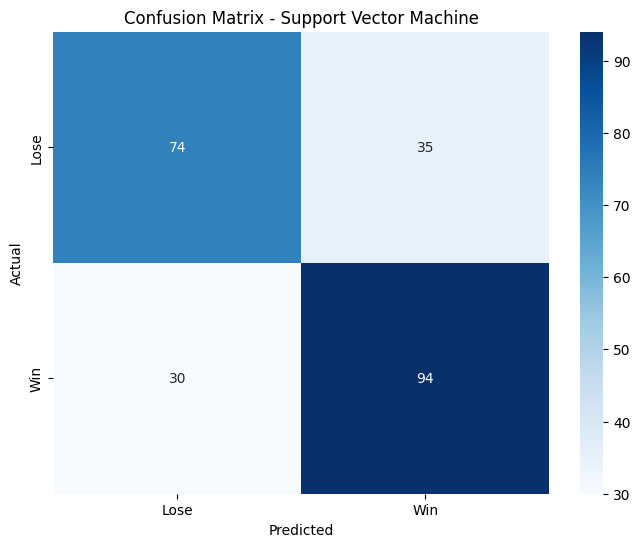

In [84]:

# Identify best model
best_model_name = performance_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_accuracy = performance_df.iloc[0]['Test Accuracy']

print(f"\n BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {best_accuracy:.3f}")
print(f"   CV Accuracy: {performance_df.iloc[0]['CV Accuracy (Mean)']:.3f}")

# Detailed analysis of best model
print(f"\nDETAILED ANALYSIS OF BEST MODEL ({best_model_name}):")

# Use scaled data if needed for best model
if best_model_name in ['Logistic Regression', 'K-Nearest Neighbors', 'Support Vector Machine']:
    X_test_for_best = ml_data['X_test_scaled']
else:
    X_test_for_best = ml_data['X_test']

y_pred_best = results[best_model_name]['y_pred']
y_pred_proba_best = results[best_model_name]['y_pred_proba']

print("Classification Report:")
print(classification_report(ml_data['y_test'], y_pred_best))

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(ml_data['y_test'], y_pred_best)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Lose', 'Win'], 
            yticklabels=['Lose', 'Win'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature Importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    print(f"\nFEATURE IMPORTANCE ({best_model_name}):")
    feature_importance = pd.DataFrame({
        'feature': ml_data['feature_names'],
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(feature_importance.head(10).round(4))
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title(f'Top 15 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()

## 4.2 Advanced performance analysis

In [85]:

# 1. Performance by match difficulty
print("1. PERFORMANCE BY MATCH DIFFICULTY:")

# Create match difficulty categories based on strength difference
ml_data['X_test']['strength_diff_category'] = pd.cut(
    ml_data['X_test']['overall_strength_diff'], 
    bins=[-float('inf'), -10, -5, 5, 10, float('inf')],
    labels=['Very Hard', 'Hard', 'Balanced', 'Easy', 'Very Easy']
)

# Add predictions to test data for analysis
test_with_predictions = ml_data['X_test'].copy()
test_with_predictions['actual'] = ml_data['y_test']
test_with_predictions['predicted'] = results[best_model_name]['y_pred']
test_with_predictions['correct'] = test_with_predictions['actual'] == test_with_predictions['predicted']

# Analyze accuracy by match difficulty
difficulty_accuracy = test_with_predictions.groupby('strength_diff_category')['correct'].mean()
print("Accuracy by match difficulty:")
for difficulty, acc in difficulty_accuracy.items():
    count = (test_with_predictions['strength_diff_category'] == difficulty).sum()
    print(f"  - {difficulty}: {acc:.3f} ({count} matches)")

# 2. Performance by target runs
print(f"\n2. PERFORMANCE BY TARGET SIZE:")
test_with_predictions['target_category'] = pd.cut(
    test_with_predictions['target_runs'],
    bins=[0, 140, 160, 180, 200, float('inf')],
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
)

target_accuracy = test_with_predictions.groupby('target_category')['correct'].mean()
print("Accuracy by target runs:")
for target, acc in target_accuracy.items():
    count = (test_with_predictions['target_category'] == target).sum()
    print(f"  - {target}: {acc:.3f} ({count} matches)")

# 3. Error analysis
print(f"\n3. ERROR ANALYSIS:")
wrong_predictions = test_with_predictions[~test_with_predictions['correct']]
print(f"Total wrong predictions: {len(wrong_predictions)}")

if len(wrong_predictions) > 0:
    print("Sample of wrong predictions:")
    wrong_sample = wrong_predictions.head(5)[[
        'target_runs', 'overall_strength_diff', 'actual', 'predicted'
    ]]
    print(wrong_sample)
    
    # Analyze common patterns in wrong predictions
    print("\nCommon patterns in wrong predictions:")
    print(f"  - Average target runs: {wrong_predictions['target_runs'].mean():.1f}")
    print(f"  - Average strength diff: {wrong_predictions['overall_strength_diff'].mean():.1f}")
    print(f"  - Wrong when chasing should win: {(wrong_predictions['actual'] == 1).sum()} times")
    print(f"  - Wrong when chasing should lose: {(wrong_predictions['actual'] == 0).sum()} times")

1. PERFORMANCE BY MATCH DIFFICULTY:
Accuracy by match difficulty:
  - Very Hard: 0.833 (6 matches)
  - Hard: 0.676 (34 matches)
  - Balanced: 0.704 (162 matches)
  - Easy: 0.852 (27 matches)
  - Very Easy: 0.750 (4 matches)

2. PERFORMANCE BY TARGET SIZE:
Accuracy by target runs:
  - Very Low: 0.810 (42 matches)
  - Low: 0.738 (42 matches)
  - Medium: 0.644 (73 matches)
  - High: 0.684 (38 matches)
  - Very High: 0.789 (38 matches)

3. ERROR ANALYSIS:
Total wrong predictions: 65
Sample of wrong predictions:
     target_runs  overall_strength_diff  actual  predicted
148        201.0               1.918747       1          0
197        165.0               0.105854       0          1
675        188.0               2.551112       1          0
952        172.0               0.935133       1          0
299        188.0               3.393200       1          0

Common patterns in wrong predictions:
  - Average target runs: 170.3
  - Average strength diff: -0.9
  - Wrong when chasing should w

## 4.3 Saving models

In [86]:

import pickle
import joblib

# Save all models and results
model_package = {
    'results': results,
    'trained_models': trained_models,
    'best_model': best_model,
    'best_model_name': best_model_name,
    'ml_data': ml_data,
    'performance_df': performance_df
}

# Save using joblib (better for large models)
joblib.dump(model_package, 'outputs/ml_step4_trained_models.pkl')

# Save best model separately for easy loading
joblib.dump(best_model, 'outputs/best_model.pkl')

print(" Models saved:")
print("   - outputs/ml_step4_trained_models.pkl (all models + results)")
print("   - outputs/best_model.pkl (best model only)")

# Save performance summary
performance_df.to_csv('outputs/model_performance_summary.csv', index=False)
print("   - outputs/model_performance_summary.csv (performance comparison)")

print(f"\nFINAL RESULTS SUMMARY:")
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {best_accuracy:.1%}")
print(f"Baseline (always predict majority): {max(ml_data['y_test'].mean(), 1-ml_data['y_test'].mean()):.1%}")
print(f"Improvement over baseline: {best_accuracy - max(ml_data['y_test'].mean(), 1-ml_data['y_test'].mean()):+.1%}")

 Models saved:
   - outputs/ml_step4_trained_models.pkl (all models + results)
   - outputs/best_model.pkl (best model only)
   - outputs/model_performance_summary.csv (performance comparison)

FINAL RESULTS SUMMARY:
Best Model: Support Vector Machine
Test Accuracy: 72.1%
Baseline (always predict majority): 53.2%
Improvement over baseline: +18.9%


## 4.4 Prediction dashboard


In [87]:
def create_prediction_system(trained_models, ml_data, results):
    """
    Step 5: Create a system to make new predictions and show results
    """
    print("Setting up prediction system...")
    
    # Get the best model
    best_model_name = list(results.keys())[0]  # Assuming sorted by performance
    best_model = results[best_model_name]['model']
    
    # Determine if we need scaled data for the best model
    needs_scaling = best_model_name in ['Logistic Regression', 'K-Nearest Neighbors', 'Support Vector Machine']
    
    print(f"Using {best_model_name} for predictions {'(with scaling)' if needs_scaling else ''}")
    
    def predict_match(chasing_team, defending_team, target_runs, first_innings_runs, 
                     venue, toss_winner, toss_decision, season):
        """
        Predict win probability for a new match
        """
        try:
            # Create feature vector for the new match
            new_match_features = {}
            
            # Basic match features
            new_match_features['target_runs'] = target_runs
            new_match_features['first_innings_runs'] = first_innings_runs
            new_match_features['first_innings_wickets'] = 5  # Average wickets
            new_match_features['required_run_rate'] = target_runs / 20
            new_match_features['is_toss_winner_chasing'] = 1 if toss_winner == chasing_team else 0
            new_match_features['is_batting_first_won_toss'] = 1 if toss_decision == 'bat' else 0
            
            # Get team strengths (from our team strength data)
            chasing_strength = team_strength_enhanced[
                (team_strength_enhanced['Team'] == chasing_team) & 
                (team_strength_enhanced['Season'] == season)
            ]
            defending_strength = team_strength_enhanced[
                (team_strength_enhanced['Team'] == defending_team) & 
                (team_strength_enhanced['Season'] == season)
            ]
            
            # Fill team strength features
            if len(chasing_strength) > 0:
                new_match_features['chasing_overall_strength'] = chasing_strength['Overall_Strength'].iloc[0]
                new_match_features['chasing_batting_strength'] = chasing_strength['Batting_Strength'].iloc[0]
                new_match_features['chasing_bowling_strength'] = chasing_strength['Bowling_Strength'].iloc[0]
                new_match_features['chasing_allrounder_strength'] = chasing_strength['AllRounder_Strength'].iloc[0]
            else:
                # Default strengths if team not found
                new_match_features.update({
                    'chasing_overall_strength': 50, 'chasing_batting_strength': 50,
                    'chasing_bowling_strength': 50, 'chasing_allrounder_strength': 50
                })
            
            if len(defending_strength) > 0:
                new_match_features['defending_overall_strength'] = defending_strength['Overall_Strength'].iloc[0]
                new_match_features['defending_batting_strength'] = defending_strength['Batting_Strength'].iloc[0]
                new_match_features['defending_bowling_strength'] = defending_strength['Bowling_Strength'].iloc[0]
                new_match_features['defending_allrounder_strength'] = defending_strength['AllRounder_Strength'].iloc[0]
            else:
                new_match_features.update({
                    'defending_overall_strength': 50, 'defending_batting_strength': 50,
                    'defending_bowling_strength': 50, 'defending_allrounder_strength': 50
                })
            
            # Calculate strength differentials
            new_match_features['overall_strength_diff'] = (
                new_match_features['chasing_overall_strength'] - new_match_features['defending_overall_strength']
            )
            new_match_features['batting_strength_diff'] = (
                new_match_features['chasing_batting_strength'] - new_match_features['defending_bowling_strength']
            )
            new_match_features['bowling_strength_diff'] = (
                new_match_features['chasing_bowling_strength'] - new_match_features['defending_batting_strength']
            )
            new_match_features['allrounder_strength_diff'] = (
                new_match_features['chasing_allrounder_strength'] - new_match_features['defending_allrounder_strength']
            )
            
            # Encode categorical variables
            for col in ['venue', 'chasing_team', 'defending_team', 'toss_winner', 'toss_decision']:
                encoder = ml_data['label_encoders'].get(col)
                if encoder:
                    try:
                        new_match_features[f'{col}_encoded'] = encoder.transform([str(locals()[col])])[0]
                    except:
                        new_match_features[f'{col}_encoded'] = 0  # Default if category not seen
            
            # Create feature vector in correct order
            feature_vector = []
            for feature in ml_data['feature_names']:
                feature_vector.append(new_match_features.get(feature, 0))
            
            # Convert to numpy array and reshape
            X_new = np.array(feature_vector).reshape(1, -1)
            
            # Scale if needed
            if needs_scaling:
                X_new = ml_data['scaler'].transform(X_new)
            
            # Make prediction
            win_probability = best_model.predict_proba(X_new)[0][1]  # Probability of winning while chasing
            prediction = best_model.predict(X_new)[0]
            
            return {
                'win_probability': win_probability,
                'prediction': 'Win' if prediction == 1 else 'Lose',
                'confidence': max(win_probability, 1 - win_probability),
                'strength_advantage': new_match_features['overall_strength_diff']
            }
            
        except Exception as e:
            print(f"Prediction error: {e}")
            return None
    
    return predict_match

# Create the prediction function
predict_match = create_prediction_system(trained_models, ml_data, results)


Setting up prediction system...
Using Logistic Regression for predictions (with scaling)


In [88]:

# Sample prediction 1: High-profile match
print("1. HIGH-PROFILE MATCH PREDICTION:")
result1 = predict_match(
    chasing_team="Royal Challengers Bangalore",
    defending_team="Mumbai Indians", 
    target_runs=185,
    first_innings_runs=184,
    venue="M Chinnaswamy Stadium",
    toss_winner="Royal Challengers Bangalore",
    toss_decision="field",
    season=2023
)

if result1:
    print(f"Match: RCB vs MI")
    print(f"Target: 185 runs")
    print(f"Prediction: {result1['prediction']} for RCB")
    print(f"Win Probability: {result1['win_probability']:.1%}")
    print(f"Confidence: {result1['confidence']:.1%}")
    print(f"Strength Advantage: {result1['strength_advantage']:+.1f}")

print("\n" + "-"*40)

# Sample prediction 2: Different scenario
print("2. DEFENDING LOW TOTAL:")
result2 = predict_match(
    chasing_team="Chennai Super Kings",
    defending_team="Kolkata Knight Riders",
    target_runs=145, 
    first_innings_runs=144,
    venue="MA Chidambaram Stadium",
    toss_winner="Kolkata Knight Riders",
    toss_decision="bat",
    season=2023
)

if result2:
    print(f"Match: CSK vs KKR")
    print(f"Target: 145 runs") 
    print(f"Prediction: {result2['prediction']} for CSK")
    print(f"Win Probability: {result2['win_probability']:.1%}")
    print(f"Confidence: {result2['confidence']:.1%}")
    print(f"Strength Advantage: {result2['strength_advantage']:+.1f}")

1. HIGH-PROFILE MATCH PREDICTION:
Match: RCB vs MI
Target: 185 runs
Prediction: Lose for RCB
Win Probability: 29.4%
Confidence: 70.6%
Strength Advantage: +0.9

----------------------------------------
2. DEFENDING LOW TOTAL:
Match: CSK vs KKR
Target: 145 runs
Prediction: Win for CSK
Win Probability: 74.7%
Confidence: 74.7%
Strength Advantage: -2.7


In [89]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_prediction_dashboard(predict_match_function):
    """
    Create an interactive dashboard for match predictions
    """
    
    def show_match_prediction(chasing_team, defending_team, target_runs, venue, season=2023):
        """
        Display prediction with visualizations
        """
        # Make prediction
        result = predict_match_function(
            chasing_team=chasing_team,
            defending_team=defending_team,
            target_runs=target_runs,
            first_innings_runs=target_runs - 1,  # Assume close match
            venue=venue,
            toss_winner=chasing_team,  # Assume toss winner chases
            toss_decision="field",
            season=season
        )
        
        if not result:
            print("Prediction failed")
            return
        
        # Create visualization
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Win Probability', 'Strength Comparison', 'Key Factors', 'Match Context'),
            specs=[[{"type": "indicator"}, {"type": "bar"}],
                   [{"type": "bar"}, {"type": "table"}]],
            vertical_spacing=0.15,
            horizontal_spacing=0.1
        )
        
        # 1. Win Probability Gauge
        fig.add_trace(
            go.Indicator(
                mode="gauge+number+delta",
                value=result['win_probability'] * 100,
                domain={'x': [0, 1], 'y': [0, 1]},
                title={'text': f"Win Probability for {chasing_team}"},
                delta={'reference': 50},
                gauge={
                    'axis': {'range': [None, 100]},
                    'bar': {'color': "darkblue"},
                    'steps': [
                        {'range': [0, 30], 'color': "lightcoral"},
                        {'range': [30, 70], 'color': "lightyellow"},
                        {'range': [70, 100], 'color': "lightgreen"}
                    ],
                    'threshold': {
                        'line': {'color': "red", 'width': 4},
                        'thickness': 0.75,
                        'value': 90
                    }
                }
            ),
            row=1, col=1
        )
        
        # 2. Strength Comparison
        teams = [chasing_team, defending_team]
        strength_vals = [50 + result['strength_advantage']/2, 50 - result['strength_advantage']/2]
        
        fig.add_trace(
            go.Bar(
                x=teams,
                y=strength_vals,
                marker_color=['lightgreen', 'lightcoral'],
                text=strength_vals,
                texttemplate='%{text:.0f}',
                textposition='auto'
            ),
            row=1, col=2
        )
        
        # 3. Key Factors (simplified)
        factors = ['Target Difficulty', 'Strength Advantage', 'Venue Factor', 'Toss Advantage']
        factor_scores = [
            max(0, 100 - (target_runs - 150)),  # Target difficulty
            min(100, max(0, 50 + result['strength_advantage'] * 5)),  # Strength
            75,  # Venue (placeholder)
            60   # Toss (placeholder)
        ]
        
        fig.add_trace(
            go.Bar(
                x=factor_scores,
                y=factors,
                orientation='h',
                marker_color='lightblue'
            ),
            row=2, col=1
        )
        
        # 4. Match Context Table
        fig.add_trace(
            go.Table(
                header=dict(values=['Parameter', 'Value']),
                cells=dict(values=[
                    ['Teams', 'Target', 'Venue', 'Prediction', 'Confidence'],
                    [f"{chasing_team} vs {defending_team}", f"{target_runs} runs", 
                     venue, result['prediction'], f"{result['confidence']:.1%}"]
                ])
            ),
            row=2, col=2
        )
        
        fig.update_layout(
            title=f"IPL Match Prediction: {chasing_team} vs {defending_team}",
            height=600,
            showlegend=False
        )
        
        fig.show()
        
        # Print detailed analysis
        print(f"\n🔍 DETAILED ANALYSIS:")
        print(f"Match: {chasing_team} vs {defending_team}")
        print(f"Target: {target_runs} runs at {venue}")
        print(f"Prediction: {result['prediction']} for {chasing_team}")
        print(f"Win Probability: {result['win_probability']:.1%}")
        print(f"Confidence: {result['confidence']:.1%}")
        print(f"Strength Advantage: {result['strength_advantage']:+.1f}")
        
        # Interpretation
        if result['win_probability'] > 0.7:
            print("Interpretation: STRONG FAVORITE - High chance of winning")
        elif result['win_probability'] > 0.55:
            print("Interpretation: SLIGHT FAVORITE - Better chances")
        elif result['win_probability'] > 0.45:
            print("Interpretation: TOSS-UP - Very close match")
        else:
            print("Interpretation: UNDERDOG - Tough challenge")
    
    return show_match_prediction

# Create the dashboard function
show_prediction = create_prediction_dashboard(predict_match)

print("Interactive dashboard created!")

# Demo the dashboard with a sample match
print("\n🎮 DEMO: PREDICTION DASHBOARD")
print("Launching dashboard for sample match...")

# Show a sample prediction
show_prediction(
    chasing_team="Royal Challengers Bangalore",
    defending_team="Chennai Super Kings", 
    target_runs=175,
    venue="M Chinnaswamy Stadium",
    season=2023
)

Interactive dashboard created!

🎮 DEMO: PREDICTION DASHBOARD
Launching dashboard for sample match...



🔍 DETAILED ANALYSIS:
Match: Royal Challengers Bangalore vs Chennai Super Kings
Target: 175 runs at M Chinnaswamy Stadium
Prediction: Lose for Royal Challengers Bangalore
Win Probability: 37.0%
Confidence: 63.0%
Strength Advantage: +3.8
Interpretation: UNDERDOG - Tough challenge


## 4.5 Prediction vs Actual outcomes

In [90]:
def compare_predictions_vs_actual(trained_models, ml_data, results, features_with_strength):
    """
    Compare model predictions against actual match outcomes
    """
    print("Comparing predictions against actual outcomes...")
    
    # Get the best model
    best_model_name = list(results.keys())[0]
    best_model = results[best_model_name]['model']
    
    # Determine if we need scaled data
    needs_scaling = best_model_name in ['Logistic Regression', 'K-Nearest Neighbors', 'Support Vector Machine']
    
    # Get test set predictions
    if needs_scaling:
        X_test_for_model = ml_data['X_test_scaled']
    else:
        X_test_for_model = ml_data['X_test']
    
    # Get predictions for all test matches
    test_predictions = best_model.predict(X_test_for_model)
    test_probabilities = best_model.predict_proba(X_test_for_model)[:, 1]
    
    # Create comparison dataframe
    comparison_df = features_with_strength.iloc[ml_data['X_test'].index].copy()
    comparison_df['predicted_win'] = test_predictions
    comparison_df['predicted_win_prob'] = test_probabilities
    comparison_df['prediction_correct'] = comparison_df['won_chasing'] == comparison_df['predicted_win']
    
    # Add prediction confidence
    comparison_df['prediction_confidence'] = np.where(
        comparison_df['predicted_win_prob'] > 0.5,
        comparison_df['predicted_win_prob'],
        1 - comparison_df['predicted_win_prob']
    )
    
    return comparison_df

# Create comparison data
prediction_comparison = compare_predictions_vs_actual(trained_models, ml_data, results, features_with_strength)

print(f"Created comparison data for {len(prediction_comparison)} test matches")

Comparing predictions against actual outcomes...
Created comparison data for 233 test matches


In [91]:
# Overall accuracy
total_matches = len(prediction_comparison)
correct_predictions = prediction_comparison['prediction_correct'].sum()
overall_accuracy = correct_predictions / total_matches

print(f"OVERALL PREDICTION ACCURACY:")
print(f"Correct predictions: {correct_predictions}/{total_matches} ({overall_accuracy:.1%})")

# Accuracy by confidence level
print(f"\nACCURACY BY CONFIDENCE LEVEL:")
confidence_bins = [0, 0.6, 0.7, 0.8, 0.9, 1.0]
confidence_labels = ['Low (50-60%)', 'Medium (60-70%)', 'High (70-80%)', 'Very High (80-90%)', 'Extreme (90-100%)']

prediction_comparison['confidence_level'] = pd.cut(
    prediction_comparison['prediction_confidence'],
    bins=confidence_bins,
    labels=confidence_labels,
    include_lowest=True
)

confidence_accuracy = prediction_comparison.groupby('confidence_level').agg({
    'prediction_correct': ['count', 'mean']
}).round(3)

confidence_accuracy.columns = ['matches', 'accuracy']
print(confidence_accuracy)

# Accuracy by match difficulty (strength difference)
print(f"\nACCURACY BY MATCH DIFFICULTY:")
prediction_comparison['difficulty'] = pd.cut(
    abs(prediction_comparison['overall_strength_diff']),
    bins=[0, 5, 10, 15, float('inf')],
    labels=['Very Close', 'Close', 'Clear Favorite', 'Heavy Favorite']
)

difficulty_accuracy = prediction_comparison.groupby('difficulty').agg({
    'prediction_correct': ['count', 'mean']
}).round(3)

difficulty_accuracy.columns = ['matches', 'accuracy']
print(difficulty_accuracy)

OVERALL PREDICTION ACCURACY:
Correct predictions: 163/233 (70.0%)

ACCURACY BY CONFIDENCE LEVEL:
                    matches  accuracy
confidence_level                     
Low (50-60%)             57     0.614
Medium (60-70%)          59     0.610
High (70-80%)            55     0.745
Very High (80-90%)       44     0.818
Extreme (90-100%)        18     0.833

ACCURACY BY MATCH DIFFICULTY:
                matches  accuracy
difficulty                       
Very Close          162     0.691
Close                61     0.721
Clear Favorite        8     0.625
Heavy Favorite        2     1.000


In [92]:
# Show correct predictions
print("CORRECT PREDICTIONS (Sample):")
correct_predictions_df = prediction_comparison[prediction_comparison['prediction_correct'] == True]
print(f"Total correct: {len(correct_predictions_df)}")

if len(correct_predictions_df) > 0:
    sample_correct = correct_predictions_df.head(5)[[
        'chasing_team', 'defending_team', 'target_runs', 'won_chasing', 
        'predicted_win', 'predicted_win_prob', 'overall_strength_diff'
    ]]
    print(sample_correct.round(3))

# Show wrong predictions
print(f"\nWRONG PREDICTIONS (Sample):")
wrong_predictions_df = prediction_comparison[prediction_comparison['prediction_correct'] == False]
print(f"Total wrong: {len(wrong_predictions_df)}")

if len(wrong_predictions_df) > 0:
    sample_wrong = wrong_predictions_df.head(5)[[
        'chasing_team', 'defending_team', 'target_runs', 'won_chasing',
        'predicted_win', 'predicted_win_prob', 'overall_strength_diff'
    ]]
    print(sample_wrong.round(3))
    
    # Analyze patterns in wrong predictions
    print(f"\nPATTERNS IN WRONG PREDICTIONS:")
    print(f"Average target in wrong predictions: {wrong_predictions_df['target_runs'].mean():.1f} runs")
    print(f"Average strength diff in wrong predictions: {wrong_predictions_df['overall_strength_diff'].mean():.1f}")
    print(f"Wrong when chasing won: {(wrong_predictions_df['won_chasing'] == 1).sum()} times")
    print(f"Wrong when chasing lost: {(wrong_predictions_df['won_chasing'] == 0).sum()} times")

CORRECT PREDICTIONS (Sample):
Total correct: 163
                    chasing_team               defending_team  target_runs  \
330  Royal Challengers Bangalore          Sunrisers Hyderabad        162.0   
662        Kolkata Knight Riders  Royal Challengers Bangalore        176.0   
677              Kings XI Punjab        Kolkata Knight Riders        246.0   
214         Kochi Tuskers Kerala             Delhi Daredevils        141.0   
546              Kings XI Punjab        Kolkata Knight Riders        165.0   

     won_chasing  predicted_win  predicted_win_prob  overall_strength_diff  
330            1              1               0.654                  2.233  
662            1              1               0.515                  3.786  
677            0              0               0.053                 -3.330  
214            1              1               0.748                  0.353  
546            0              0               0.449                  0.497  

WRONG PREDICTIONS (

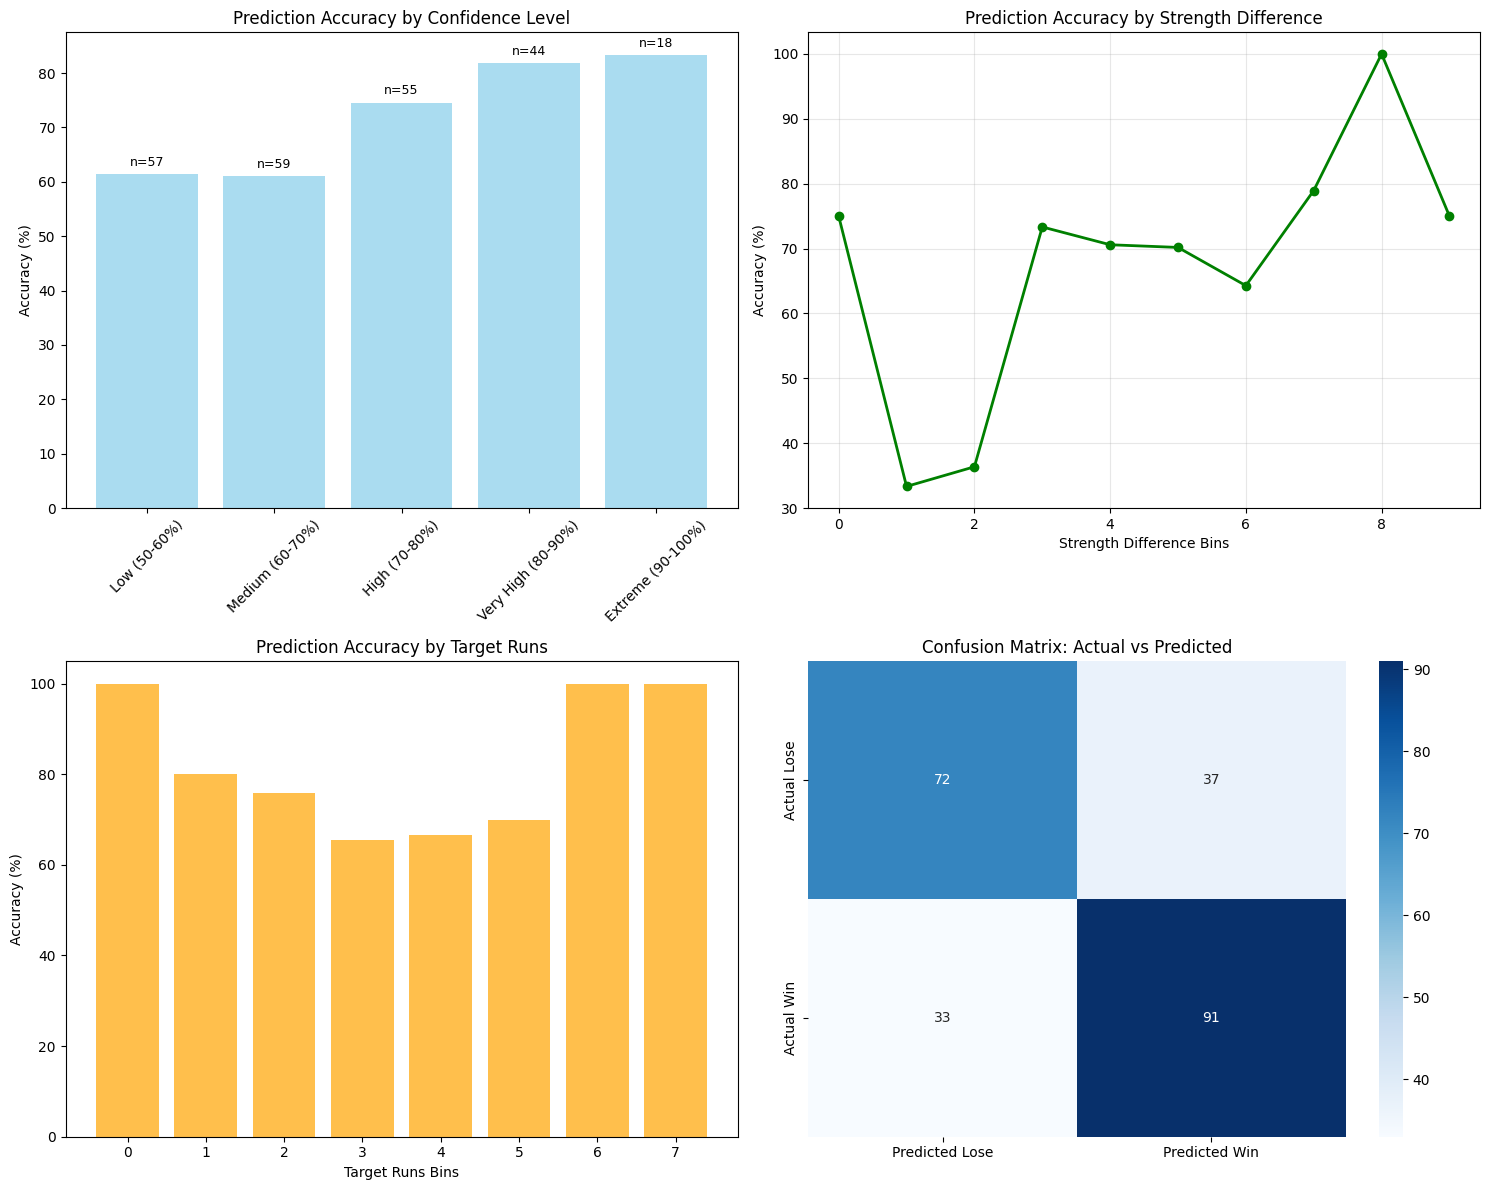

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Prediction Accuracy by Confidence
accuracy_by_confidence = prediction_comparison.groupby('confidence_level')['prediction_correct'].mean()
matches_by_confidence = prediction_comparison.groupby('confidence_level').size()

axes[0, 0].bar(accuracy_by_confidence.index, accuracy_by_confidence.values * 100, color='skyblue', alpha=0.7)
axes[0, 0].set_title('Prediction Accuracy by Confidence Level')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Add count labels
for i, (conf_level, count) in enumerate(matches_by_confidence.items()):
    axes[0, 0].text(i, accuracy_by_confidence.iloc[i] * 100 + 1, f'n={count}', 
                   ha='center', va='bottom', fontsize=9)

# 2. Strength Difference vs Prediction Accuracy
strength_bins = pd.cut(prediction_comparison['overall_strength_diff'], bins=10)
strength_accuracy = prediction_comparison.groupby(strength_bins)['prediction_correct'].mean()

axes[0, 1].plot(range(len(strength_accuracy)), strength_accuracy.values * 100, 
               marker='o', linewidth=2, color='green')
axes[0, 1].set_title('Prediction Accuracy by Strength Difference')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_xlabel('Strength Difference Bins')
axes[0, 1].grid(True, alpha=0.3)

# 3. Target Runs vs Prediction Accuracy
target_bins = pd.cut(prediction_comparison['target_runs'], bins=8)
target_accuracy = prediction_comparison.groupby(target_bins)['prediction_correct'].mean()

axes[1, 0].bar(range(len(target_accuracy)), target_accuracy.values * 100, 
               color='orange', alpha=0.7)
axes[1, 0].set_title('Prediction Accuracy by Target Runs')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].set_xlabel('Target Runs Bins')

# 4. Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(prediction_comparison['won_chasing'], prediction_comparison['predicted_win'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
            xticklabels=['Predicted Lose', 'Predicted Win'],
            yticklabels=['Actual Lose', 'Actual Win'])
axes[1, 1].set_title('Confusion Matrix: Actual vs Predicted')

plt.tight_layout()
plt.show()

In [94]:
def create_enhanced_dashboard(predict_match_function, prediction_comparison):
    """
    Create enhanced dashboard that shows prediction vs actual results
    """
    
    def show_enhanced_prediction(chasing_team, defending_team, target_runs, venue, season=2023, actual_result=None):
        """
        Show prediction with historical accuracy context
        """
        # Make prediction
        result = predict_match_function(
            chasing_team=chasing_team,
            defending_team=defending_team,
            target_runs=target_runs,
            first_innings_runs=target_runs - 1,
            venue=venue,
            toss_winner=chasing_team,
            toss_decision="field",
            season=season
        )
        
        if not result:
            print("Prediction failed")
            return
        
        # Get historical accuracy for similar matches
        similar_matches = prediction_comparison[
            (abs(prediction_comparison['target_runs'] - target_runs) < 20) &
            (abs(prediction_comparison['overall_strength_diff'] - result['strength_advantage']) < 5)
        ]
        
        similar_accuracy = similar_matches['prediction_correct'].mean() if len(similar_matches) > 0 else overall_accuracy
        
        # Create enhanced visualization
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=(
                f'Win Probability: {result["win_probability"]:.1%}', 
                'Strength Comparison',
                'Historical Accuracy Context', 
                'Prediction Details'
            ),
            specs=[[{"type": "indicator"}, {"type": "bar"}],
                   [{"type": "bar"}, {"type": "table"}]],
            vertical_spacing=0.15
        )
        
        # 1. Win Probability Gauge with color based on confidence
        gauge_color = "green" if result['confidence'] > 0.7 else "yellow" if result['confidence'] > 0.6 else "red"
        
        fig.add_trace(
            go.Indicator(
                mode="gauge+number+delta",
                value=result['win_probability'] * 100,
                domain={'x': [0, 1], 'y': [0, 1]},
                title={'text': f"Win Probability for {chasing_team}"},
                delta={'reference': 50},
                gauge={
                    'axis': {'range': [None, 100]},
                    'bar': {'color': gauge_color},
                    'steps': [
                        {'range': [0, 30], 'color': "lightcoral"},
                        {'range': [30, 70], 'color': "lightyellow"},
                        {'range': [70, 100], 'color': "lightgreen"}
                    ]
                }
            ),
            row=1, col=1
        )
        
        # 2. Strength Comparison
        teams = [chasing_team, defending_team]
        chasing_strength = 50 + result['strength_advantage'] / 2
        defending_strength = 50 - result['strength_advantage'] / 2
        
        fig.add_trace(
            go.Bar(
                x=teams,
                y=[chasing_strength, defending_strength],
                marker_color=['lightgreen', 'lightcoral'],
                text=[f'{chasing_strength:.0f}', f'{defending_strength:.0f}'],
                textposition='auto'
            ),
            row=1, col=2
        )
        
        # 3. Historical Accuracy Context
        accuracy_data = {
            'Overall': overall_accuracy,
            'Similar Matches': similar_accuracy,
            'High Confidence': confidence_accuracy.loc['Extreme (90-100%)', 'accuracy'] if 'Extreme (90-100%)' in confidence_accuracy.index else overall_accuracy
        }
        
        fig.add_trace(
            go.Bar(
                x=list(accuracy_data.keys()),
                y=[acc * 100 for acc in accuracy_data.values()],
                marker_color='lightblue',
                text=[f'{acc*100:.1f}%' for acc in accuracy_data.values()],
                textposition='auto'
            ),
            row=2, col=1
        )
        
        # 4. Prediction Details Table
        prediction_details = [
            ['Parameter', 'Value'],
            ['Match', f'{chasing_team} vs {defending_team}'],
            ['Target', f'{target_runs} runs'],
            ['Venue', venue],
            ['Prediction', f"{result['prediction']} for {chasing_team}"],
            ['Win Probability', f"{result['win_probability']:.1%}"],
            ['Confidence', f"{result['confidence']:.1%}"],
            ['Strength Advantage', f"{result['strength_advantage']:+.1f}"],
            ['Historical Accuracy', f"{similar_accuracy:.1%} (similar matches)"]
        ]
        
        if actual_result is not None:
            prediction_details.append(['Actual Result', actual_result])
            prediction_details.append(['Prediction Correct', '✅ YES' if (
                (actual_result.lower() == 'win' and result['prediction'] == 'Win') or
                (actual_result.lower() == 'lose' and result['prediction'] == 'Lose')
            ) else '❌ NO'])
        
        fig.add_trace(
            go.Table(
                header=dict(values=prediction_details[0]),
                cells=dict(values=prediction_details[1:])
            ),
            row=2, col=2
        )
        
        fig.update_layout(
            title=f"IPL Match Prediction with Historical Context",
            height=600,
            showlegend=False
        )
        
        fig.show()
        
        # Enhanced analysis
        print(f"\n🔍 ENHANCED ANALYSIS:")
        print(f"Match: {chasing_team} vs {defending_team}")
        print(f"Target: {target_runs} runs at {venue}")
        print(f"Prediction: {result['prediction']} for {chasing_team}")
        print(f"Win Probability: {result['win_probability']:.1%}")
        print(f"Confidence: {result['confidence']:.1%}")
        print(f"Strength Advantage: {result['strength_advantage']:+.1f}")
        print(f"Historical Accuracy (similar matches): {similar_accuracy:.1%}")
        
        if actual_result:
            correct_prediction = (
                (actual_result.lower() == 'win' and result['prediction'] == 'Win') or
                (actual_result.lower() == 'lose' and result['prediction'] == 'Lose')
            )
            print(f"Actual Result: {actual_result}")
            print(f"Prediction Correct: {'✅ YES' if correct_prediction else '❌ NO'}")
    
    return show_enhanced_prediction

# Create enhanced dashboard
show_enhanced_prediction = create_enhanced_dashboard(predict_match, prediction_comparison)

print("Enhanced dashboard created with actual outcome comparison")

Enhanced dashboard created with actual outcome comparison


In [95]:

print("\n" + "="*60)
print("🧪 TESTING WITH ACTUAL HISTORICAL MATCHES")
print("="*60)

# Test with some known historical matches
print("1. HISTORICAL MATCH - RCB vs CSK 2023:")
show_enhanced_prediction(
    chasing_team="Royal Challengers Bangalore",
    defending_team="Chennai Super Kings",
    target_runs=227,
    venue="M Chinnaswamy Stadium", 
    season=2023,
    actual_result="Lose"  # CSK won this match
)

print("\n" + "-"*50)

print("2. HISTORICAL MATCH - MI vs GT 2023:")
show_enhanced_prediction(
    chasing_team="Gujarat Titans", 
    defending_team="Mumbai Indians",
    target_runs=171,
    venue="Wankhede Stadium",
    season=2023,
    actual_result="Win"  # GT won this match
)


🧪 TESTING WITH ACTUAL HISTORICAL MATCHES
1. HISTORICAL MATCH - RCB vs CSK 2023:



🔍 ENHANCED ANALYSIS:
Match: Royal Challengers Bangalore vs Chennai Super Kings
Target: 227 runs at M Chinnaswamy Stadium
Prediction: Lose for Royal Challengers Bangalore
Win Probability: 9.9%
Confidence: 90.1%
Strength Advantage: +3.8
Historical Accuracy (similar matches): 84.6%
Actual Result: Lose
Prediction Correct: ✅ YES

--------------------------------------------------
2. HISTORICAL MATCH - MI vs GT 2023:



🔍 ENHANCED ANALYSIS:
Match: Gujarat Titans vs Mumbai Indians
Target: 171 runs at Wankhede Stadium
Prediction: Win for Gujarat Titans
Win Probability: 67.7%
Confidence: 67.7%
Strength Advantage: +2.8
Historical Accuracy (similar matches): 64.1%
Actual Result: Win
Prediction Correct: ✅ YES
